# Lab 8 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Modelos Generativos

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Parte I : Compressão com AE

- Parte II : Detecção de anomalias

- Parte III: Redes Generativas Adversariais

Data da entrega : 12/12/23

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/SyQggcn7S2xQaMud9)

Este notebook é baseado em tensorflow e Keras.


# Parte I: Autoencoder para redução de dimensionalidade (30pt)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Carrega dataset Fashon MNIST dataset.
Cada imagem tem resolução 28x28 pixels.

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Exemplo de classes
![mnist fashion](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)




Abaixo exemplo de implementação de autoencoder apena com camadas densas. O  `encoder`, comprime as imegns em 4 dimensões (latent_dim), e o `decoder` reconstróe a imagem a partir do vetor latente.

O exemplo abaixo usa a [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [4]:
latent_dims = [2, 4, 8, 16, 64]

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoders = []

for dim in latent_dims:
    autoencoder = Autoencoder(latent_dim=dim)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))
    autoencoders.append(autoencoder)


Epoch 1/10
1875/1875 [==============================] - 10s 3ms/step - loss: 0.0670 - val_loss: 0.0578
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0541 - val_loss: 0.0503
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0480 - val_loss: 0.0461
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0452 - val_loss: 0.0445
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0443 - val_loss: 0.0442
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0443 - val_loss: 0.0441
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0442 - val_loss: 0.0441
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0442 - val_loss: 0.0441
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.04



Treine o modelo e veja os resultados da re-construção.

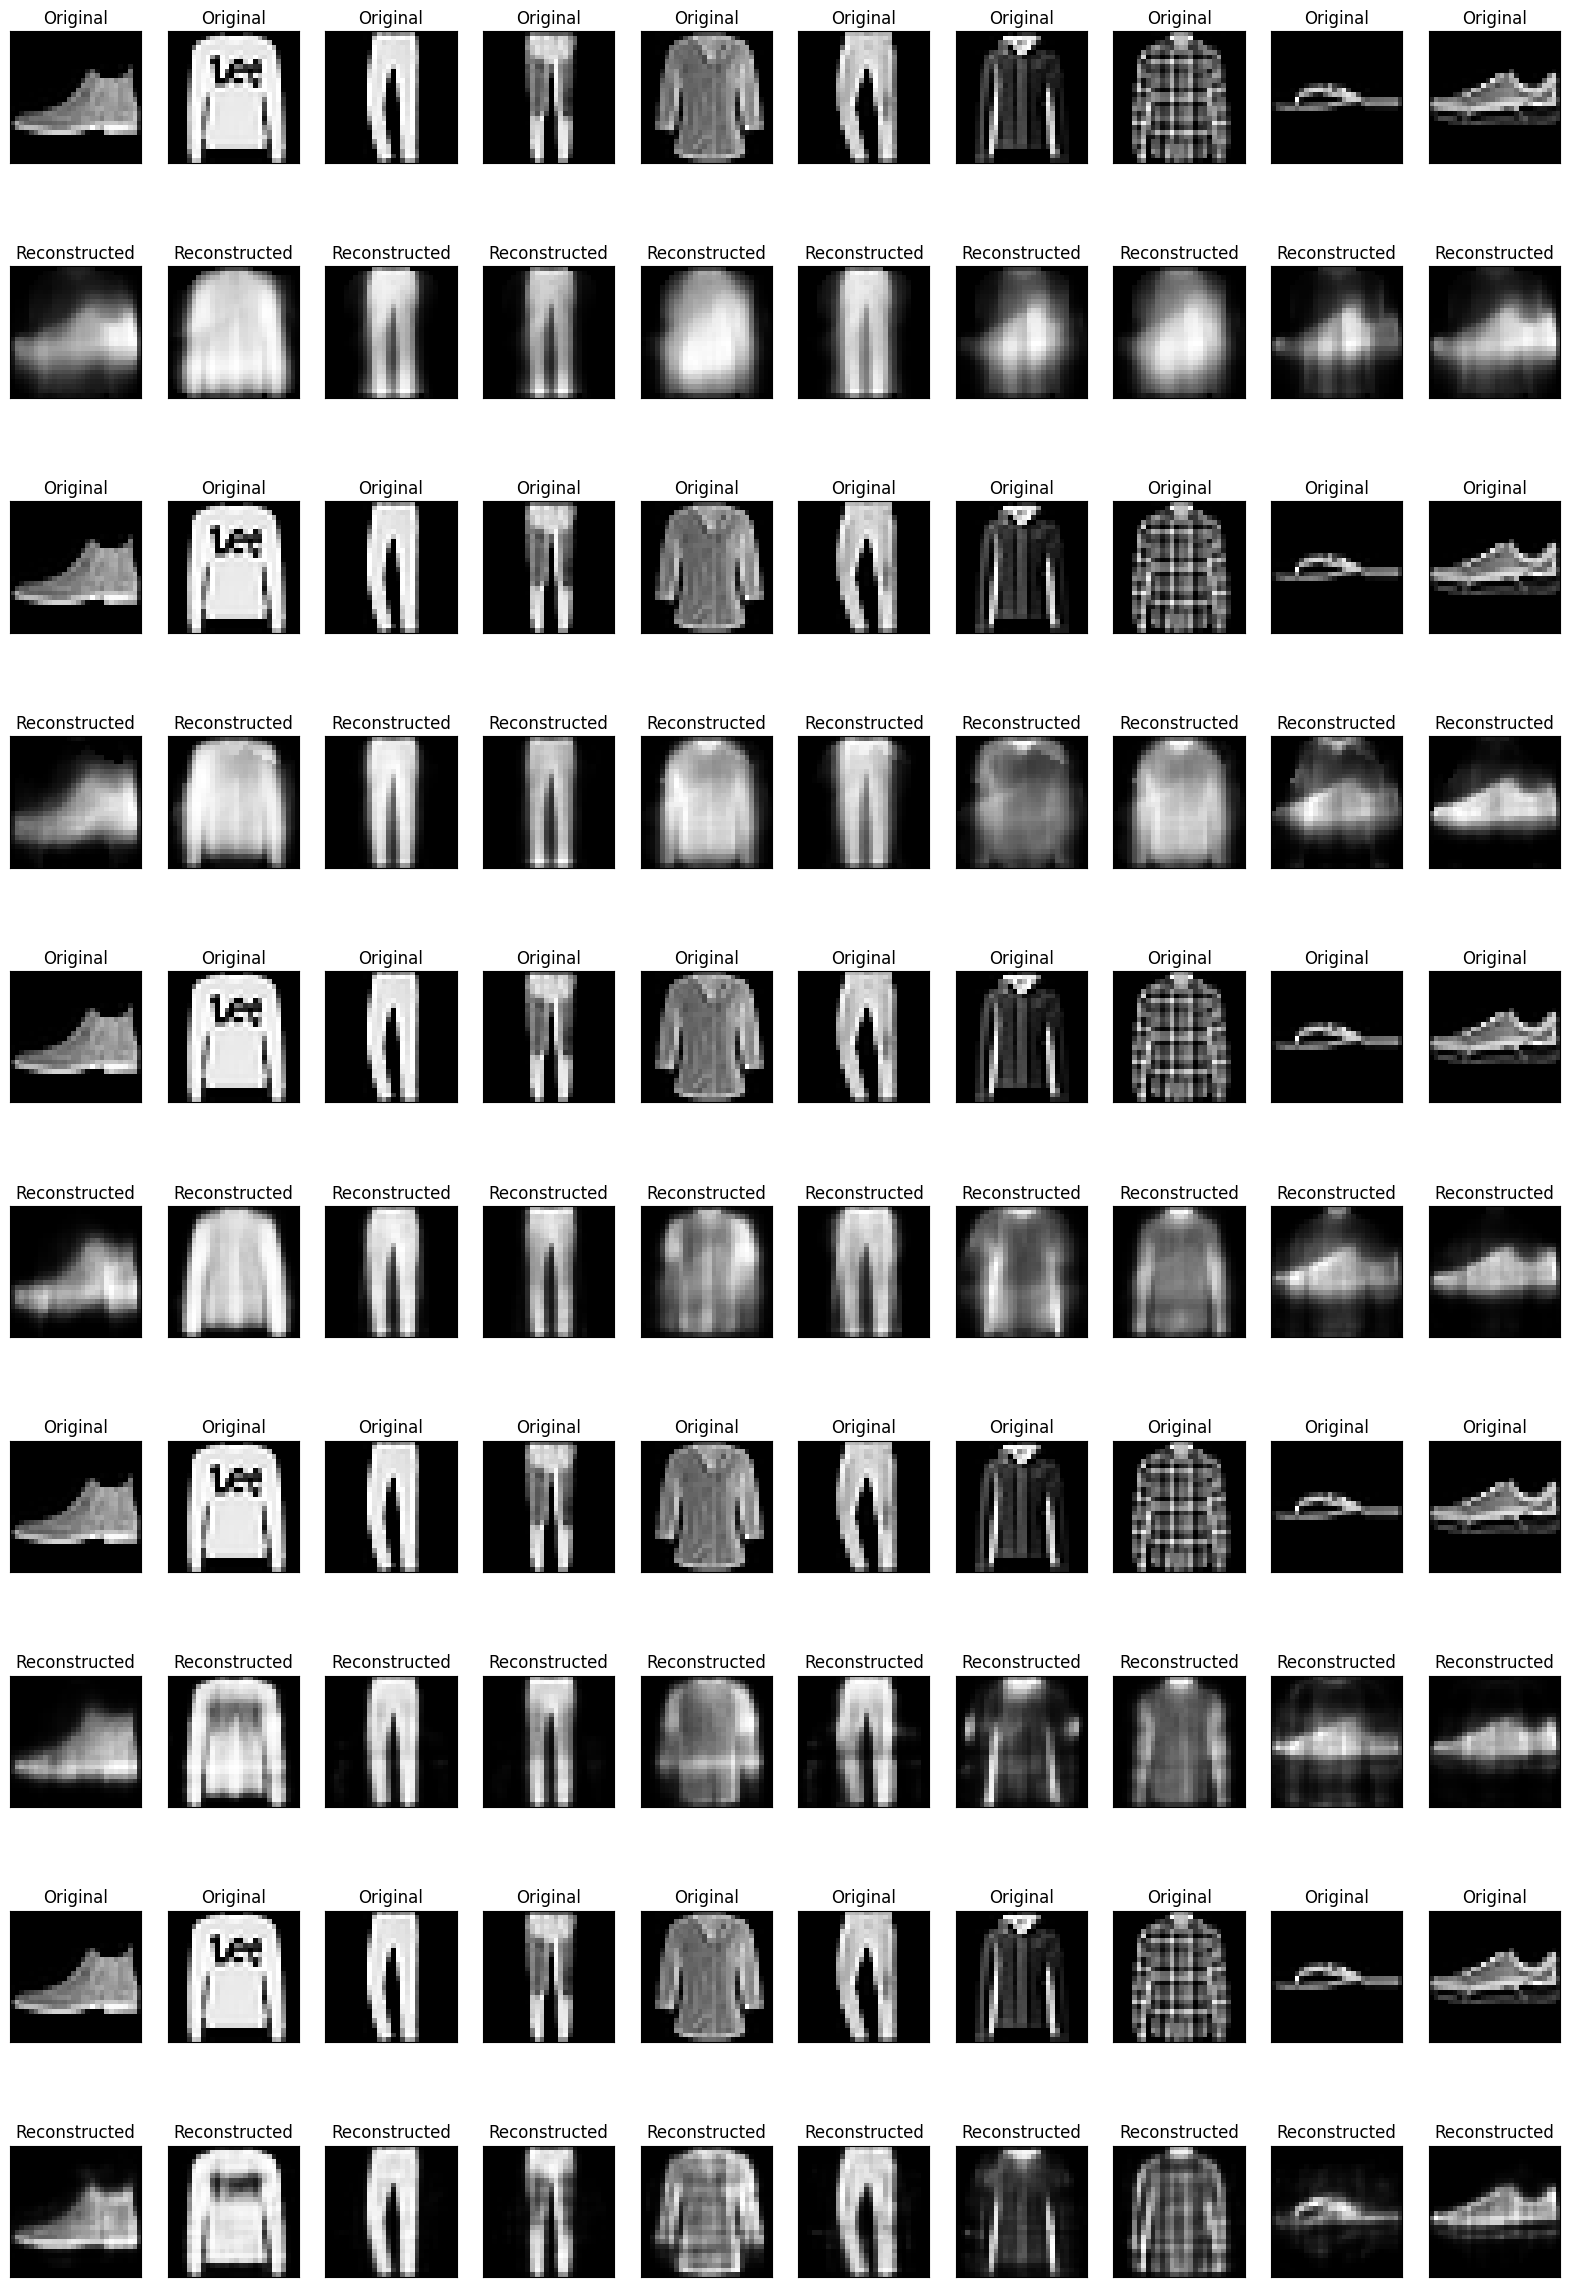

In [5]:
# Exibição das imagens para todos os modelos em uma única figura
n_models = len(latent_dims)
n_images = 10
vertical_space = 2

plt.figure(figsize=(20, (4 + vertical_space) * n_models))

for i, (dim, autoencoder) in enumerate(zip(latent_dims, autoencoders), 1):
    encoded_imgs = autoencoder.encoder(x_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    #plt.text(n_images // 2, -1, f'Latent Dim: {dim}', ha='center', va='center', fontsize=12)

    for j in range(n_images):
        # display original
        ax = plt.subplot(n_models * 2, n_images, (i-1) * (n_images * 2) + j + 1)
        plt.imshow(x_test[j])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    for j in range(n_images):
        # display reconstruction
        ax = plt.subplot(n_models * 2, n_images, (i-1) * (n_images * 2) + n_images + j + 1)
        plt.imshow(decoded_imgs[j])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

## ToDo : Testes (15pt)

Faça testes com vetor latente de dimensões 2, 8, 16 e 64.

Os testes foram realizados no próprio código acima mudando para imprimir todos os modelos com o vetor latente de dimensões diferentes.

## ToDo : Responda (15pt)

Escreva suas conclusões sobre os testes executados

Quanto maior for o vetor latente, melhor será a reconstrução da imagem.

# Parte II: Detecção de anomalias (30pt)


## Intro

Neste exemplo, você vai detectar anomalis em sinaos de eletrocardiograma (ECG). Para tal, treine um autoencoder no dataset [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Este dataset contém 5000 batimentos de ECG (https://en.wikipedia.org/wiki/Electrocardiography), cada um com 140 amostras (pontos) na curva. Cada instância da base de dados (um batimento) foi rotulado como zero (0) ou um (1). A classe zero corresponde a um batimento anormal e a classe um a um batimento de classe normal. Queremos identificar os anormais.

Para detectar anomalias usando um autoencoder você deve treinar um autoencoder apenas em batimentos normais. Ele vai aprender a re-construir os batimentos saudáveis. A hipóteses é que os batimentos anormais vão divergir no padrão, quando compararmos a entrada com a re-construção.

## Carrega base de ECG

Base de dados detalhada no site: [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [6]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [7]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normaliza entre `[0,1]`.


In [8]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Vamos separar os batimentos normais (label 1) para treinar o Autoencoder.

In [9]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plote um batimento normal.

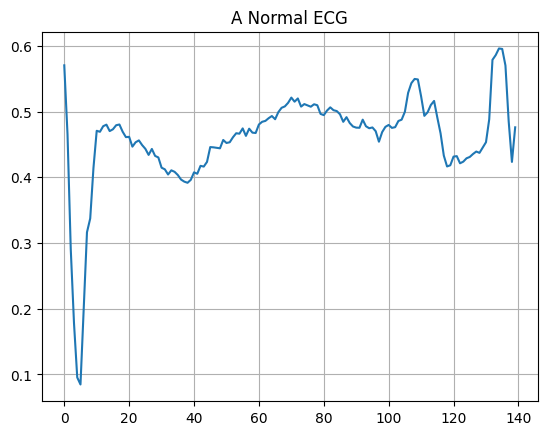

In [10]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plote um batimento anômalo.

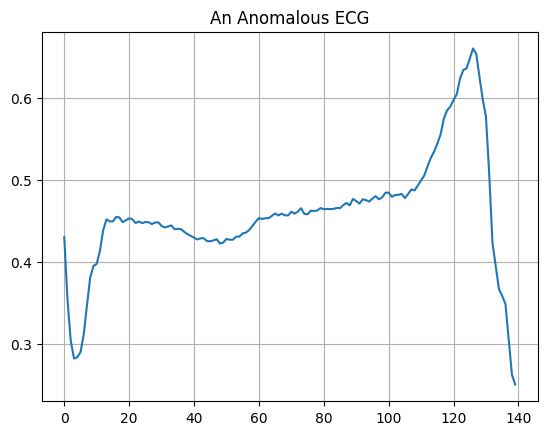

In [11]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## ToDo : Construção de um modelo (30pt)

Construa um modelo. Primeiramente tente construir apenas com camadas densas. Depois, tente construir um modelo com camadas de convolução de uma dimensão (Lembre-se que um sinal de ECG é uma série temporal de uma dimensão). [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)

In [12]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(140, activation='sigmoid'),  # Output size should match input size
        layers.Reshape((140, 1))
    ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [13]:
autoencoder.compile(optimizer='adam', loss='mae')

Depois de treinar com os batimentos normais, avalie com os anormais.

In [14]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 46ms/step - loss: 0.0585 - val_loss: 0.0537
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0568 - val_loss: 0.0526
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0553 - val_loss: 0.0514
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0533 - val_loss: 0.0498
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0505 - val_loss: 0.0481
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0468 - val_loss: 0.0468
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0430 - val_loss: 0.0454
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0393 - val_loss: 0.0431
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0358 - val_loss: 0.0412
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0327 - val_loss: 0.0399
Epoch 11/20
5/5 [============

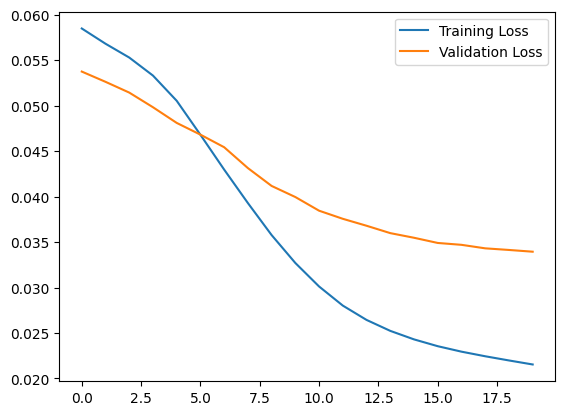

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Você vai considerar um batimento como anômalo se ele divergir masi que um desvio padrão das amostras normais. Primeiro, vamos plotar um batimento normal a partir da base de treino e sua reconstrução. Assim, poderemos calcular o erro de re-construção.

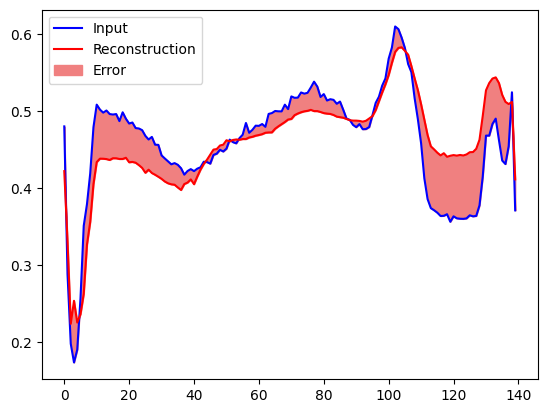

In [16]:
encoded_data = autoencoder.encoder(tf.reshape(normal_test_data, (-1, 140))).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()


plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')

decoded_data = np.squeeze(decoded_data)

plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Imagem esperada:

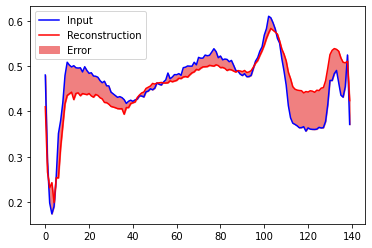



Vamos fazer o mesmo para um batimento anômalo.

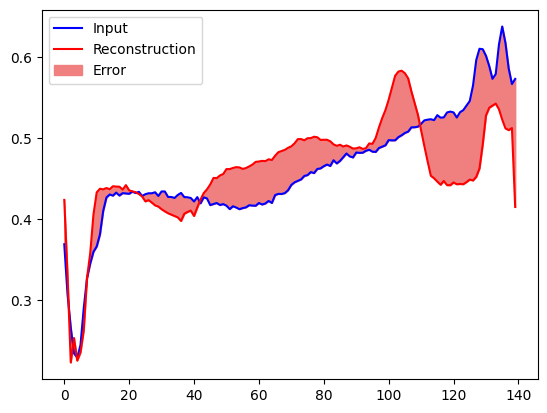

In [17]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
decoded_data = np.squeeze(decoded_data)
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Imagem esperada:

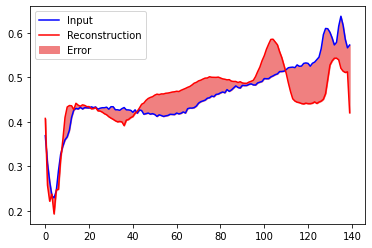

## Detectando as anomalias

Vamos detectar as anomalis se o erro de reconstrução for maior que um limiar. Aqui, vamos calcular o erro médio para os exemp;los normais do treino e depois, classificar os anormais do teste, que tenha erro de reconstrução maior que um desvio padrão.


Plota erro de reconstrução de batimentos normais do treino

74/74 [==============================] - 0s 2ms/step


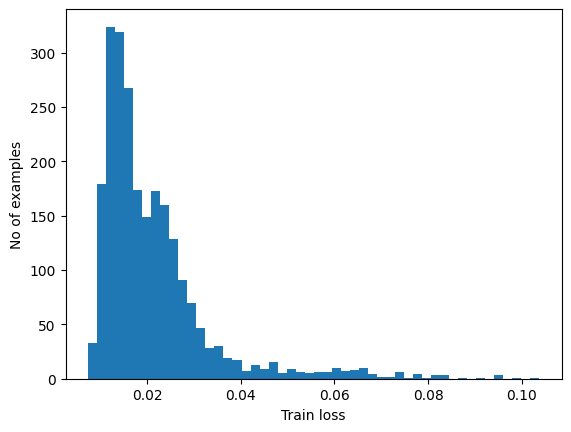

In [18]:
reconstructions = autoencoder.predict(normal_train_data)
reconstructions = tf.squeeze(reconstructions, axis=-1)

train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Escolha do limiar.

In [19]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03356406


14/14 [==============================] - 0s 2ms/step


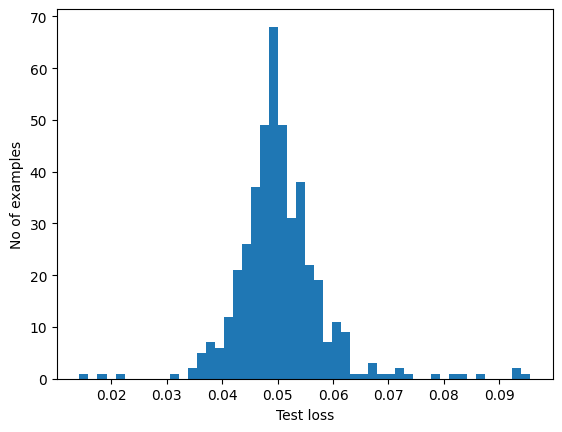

In [20]:
reconstructions = autoencoder.predict(anomalous_test_data)
reconstructions = tf.squeeze(reconstructions, axis=-1)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classificação.

In [21]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

Calcule a acurácia para os dois modelos (com camadas densas e convolucionais)

In [29]:
print("Dimensões de reconstructions:", reconstructions.shape)
print("Dimensões de data:", data.shape)
data_subset = data[:440, :]

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Dimensões de reconstructions: (440, 140)
Dimensões de data: (4998, 140)


NameError: name 'preds' is not defined

#Parte III: Redes Generativas Adversariais (40pt)

Leia o tutorial sobre a pix2pix em [Tensofrflow Tutorials](https://www.tensorflow.org/tutorials/generative/pix2pix). O pix2pix foi apresentado em [Image-to-image translation with conditional adversarial networks by Isola et al. (2017)](https://arxiv.org/abs/1611.07004) e se trata de uma rede generativa adversarial condicional para geração de fachadas de prédios condicionada a uma máscara reprtesentando a arquitetura. baixe o noterbook do tutorial, estude e treine a GAN. Após o treinamento, construa você mesmo 3 máscaras (usando algum software de desenho) e faça uma inferência com a rede. Anexe no notebook a máscara e sua respectiva saída.

## ToDo : Fachadas de prédios (40pt)

In [30]:
# ToDO : Criar 3 máscaras e gerar 3 saídas com a pix2pix para o problema de fachadas de prédios.

#Importar TensorFlow e outras bibliotecas
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

Carregar o conjunto de dados

30168306/30168306 [==============================] - 10s 0us/step
(256, 512, 3)


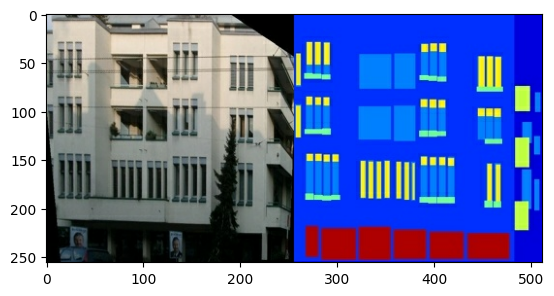

In [31]:
dataset_name = "facades"

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

list(PATH.parent.iterdir())

sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

Defina uma função que carrega arquivos de imagem e gera dois tensores de imagem:

In [32]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

plotando imagem

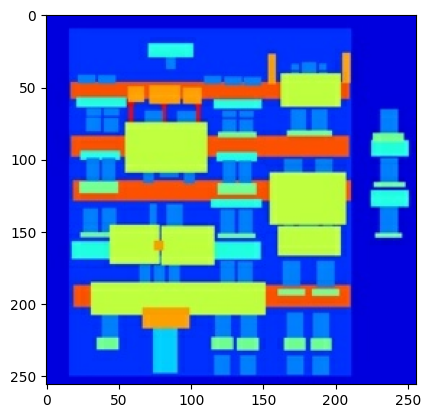

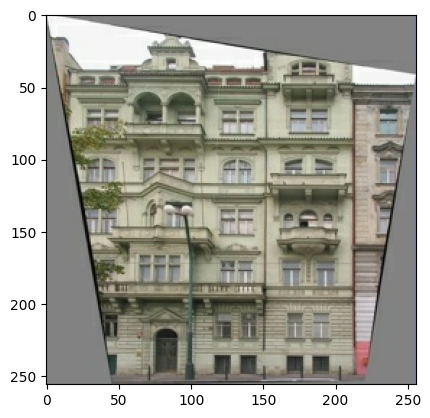

In [33]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [34]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [35]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [36]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [37]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [38]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

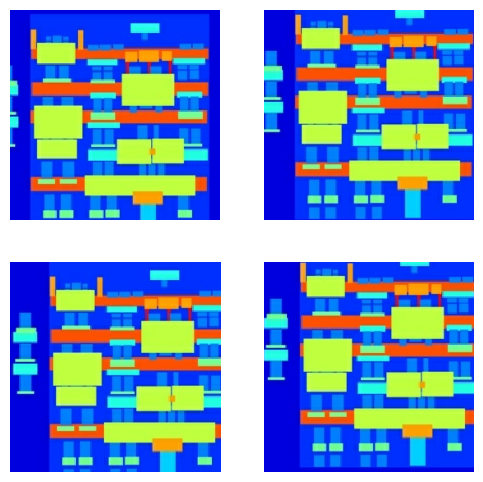

In [39]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [40]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [41]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [42]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [43]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [44]:
OUTPUT_CHANNELS = 3

In [45]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [46]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [47]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [48]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [49]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

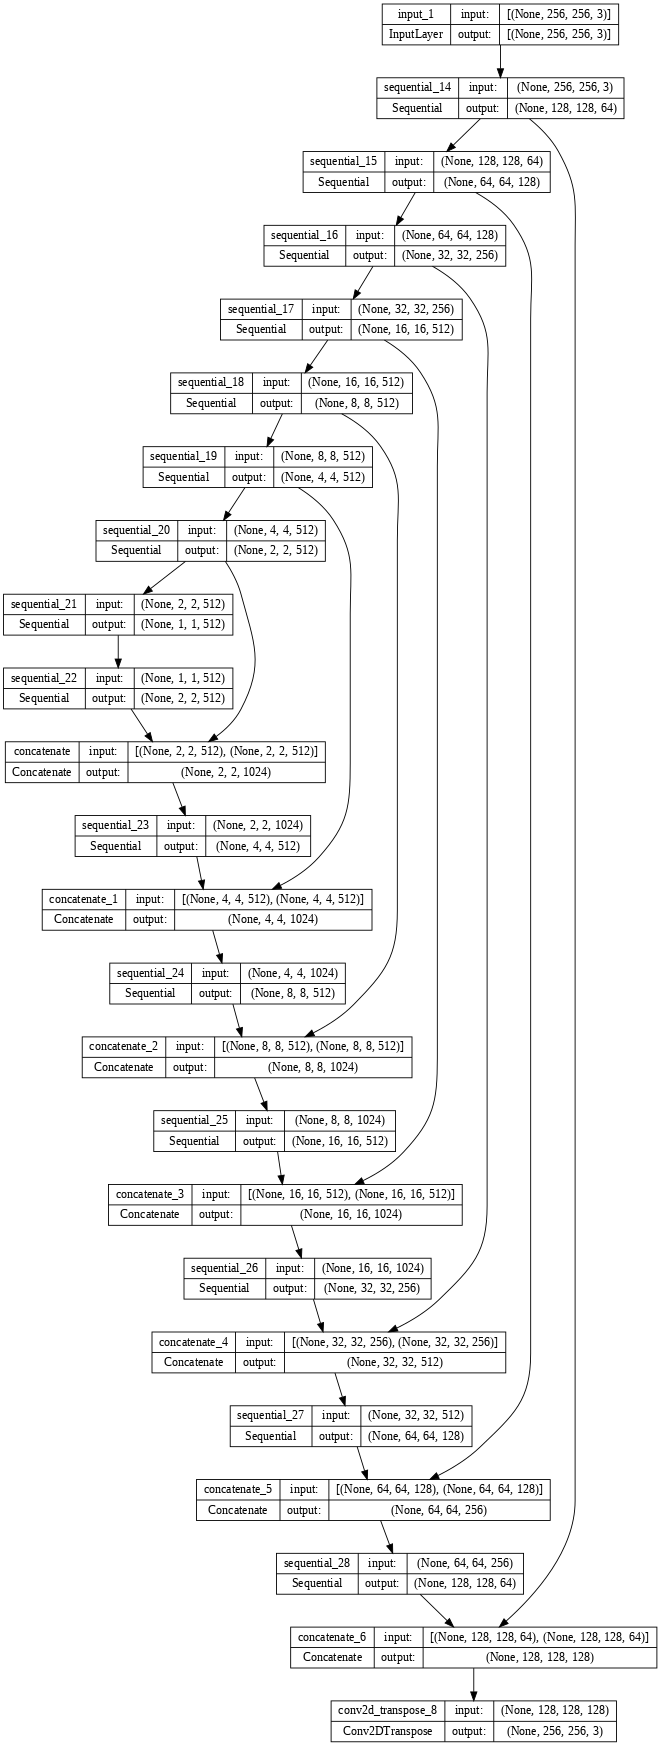

In [50]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

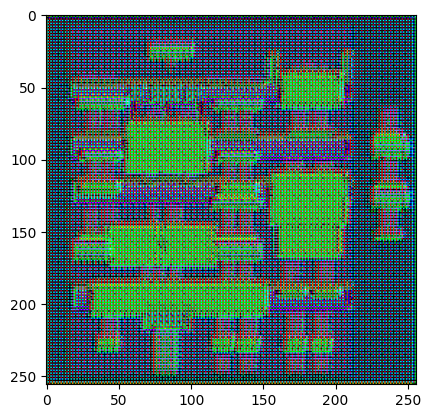

In [51]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [52]:
LAMBDA = 100

In [53]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [54]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [55]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

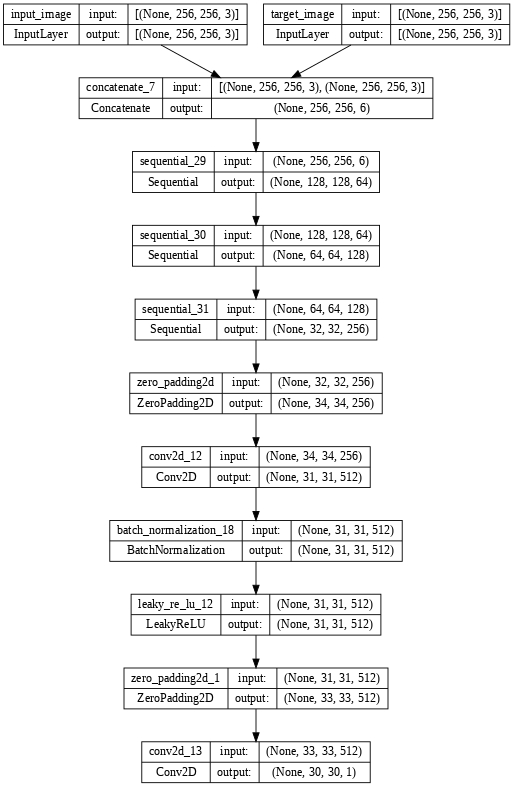

In [56]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

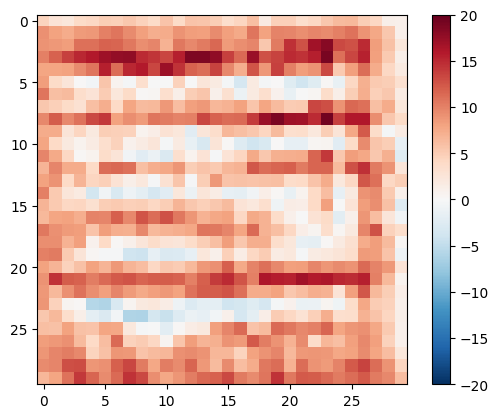

In [57]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [58]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [60]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [61]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

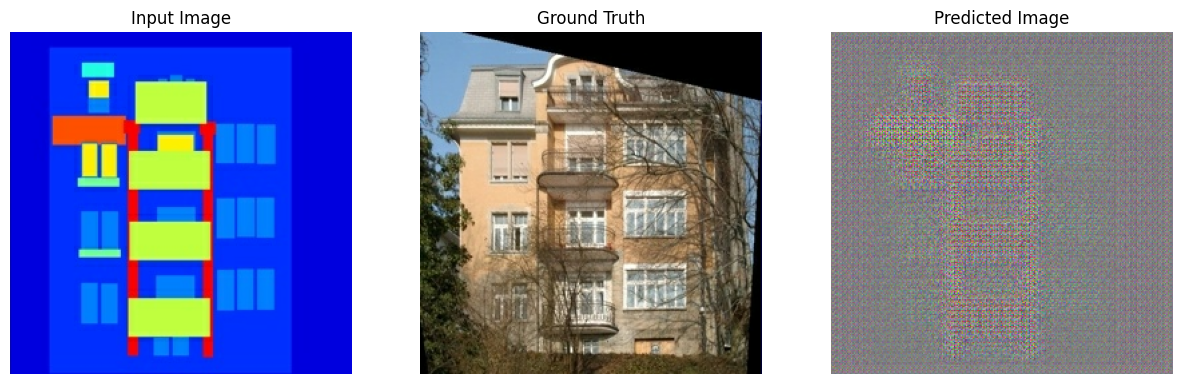

In [62]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [63]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [64]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [65]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [66]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

Time taken for 1000 steps: 92.15 sec



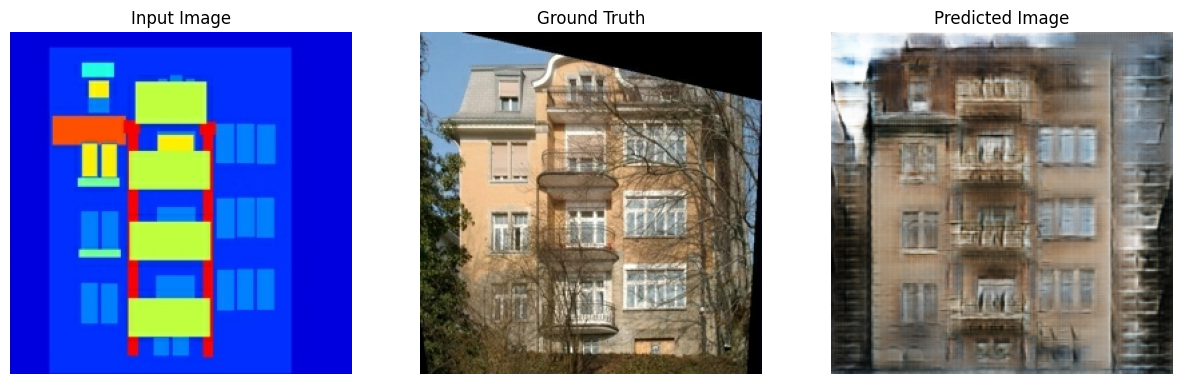

Step: 24k
..........................

KeyboardInterrupt: 

In [67]:
fit(train_dataset, test_dataset, steps=40000)

Baseado nos exemplos do tensorflow [tutorials](https://www.tensorflow.org/tutorials)
